In [1]:
import os
from math import pi

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP
from jdgsim.option_classes import SimulationConfig, SimulationParams, MNParams, PlummerParams, MN_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from jdgsim.utils import E_tot, Angular_momentum
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif, create_projection_gif
from jdgsim.potentials import MyamotoNagai



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=50, 
                          external_accelerations=(MN_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          batch_size=50, 
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (5 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=50, softening=0.010000000000000002, integrator=0, acceleration_scheme=0, batch_size=50, double_map=False, external_accelerations=(2,))
SimulationParams(G=1, t_end=3.3535437046017282, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=<Quantity 1.62e+11 solMass>, r_s=<Quantity 15.3 kpc>, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=<Quantity 1. solMass>), MN_params=MNParams(M=650.0, a=0.30000000000000004, b=0.03))


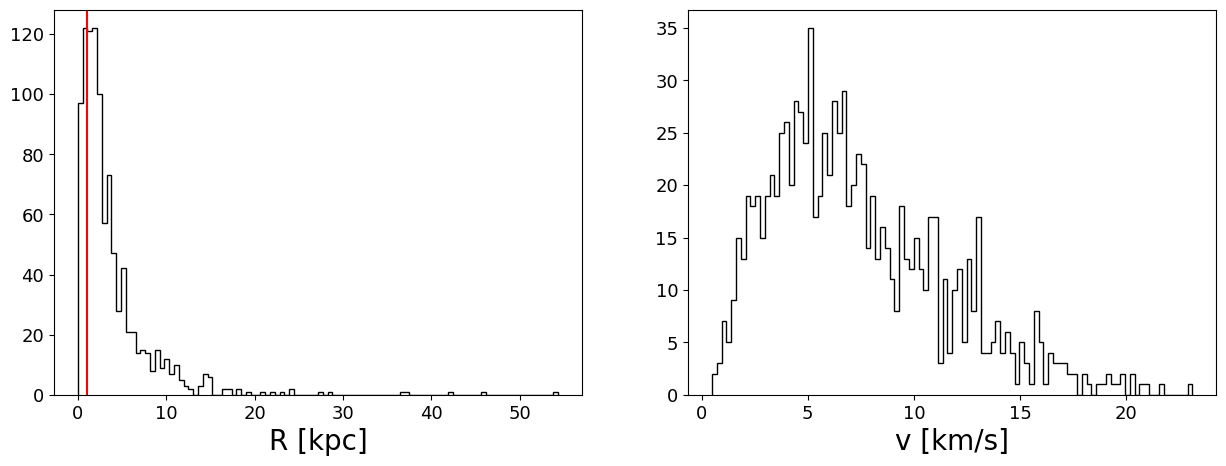

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
# radial distance of the center of mass
rp=100*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_sphere(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

# Calculate the acceleration at the center of mass
acc_com, _ = MyamotoNagai(state_com, config, params, return_potential=True)
#circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
inclination = jnp.radians(30)  # 30-degree inclination
#bulk motion to give to each particle of the Plummer sphere
vel = inclined_circular_velocity(pos, v_c, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)

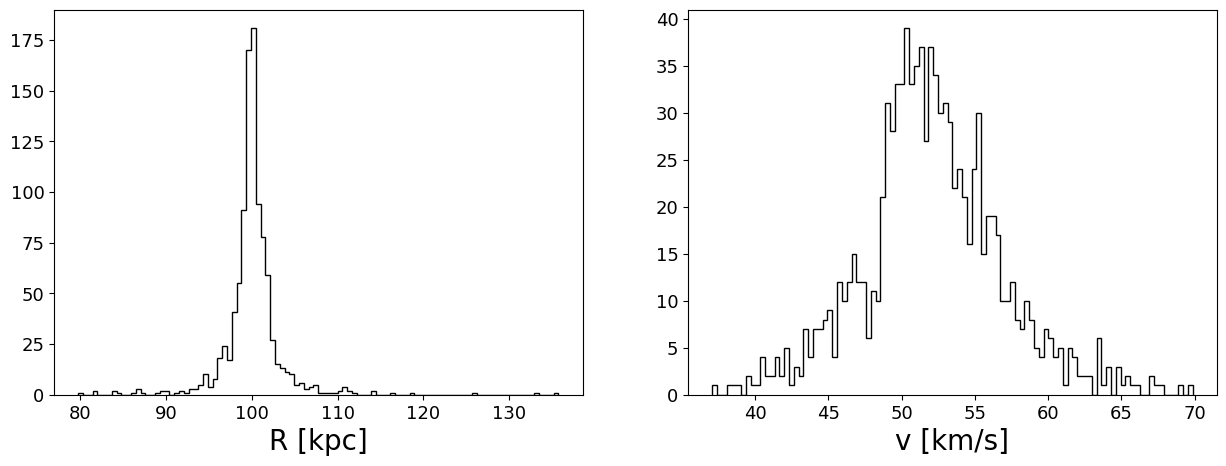

In [6]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [7]:
target_state = time_integration(initial_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(Mtot, ):
    params = SimulationParams(t_end = (5*u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=Mtot,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10  * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    pos = sample_position_on_sphere(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    # Calculate the acceleration at the center of mass
    acc_com, _ = MyamotoNagai(state_com, config, params, return_potential=True)
    #circular velocity at the center of mass
    v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
    inclination = jnp.radians(30)  # 30-degree inclination
    #bulk motion to give to each particle of the Plummer sphere
    vel = inclined_circular_velocity(pos, v_c, inclination)
    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    loss = ((Lz - Lz_target)/Lz_target)**2 

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = (0.75e8 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(Mtot, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Gradient of the total mass of the Plummer sphere:
 -2.322362302787246e-06
Loss:
 2.704551062542596e-07


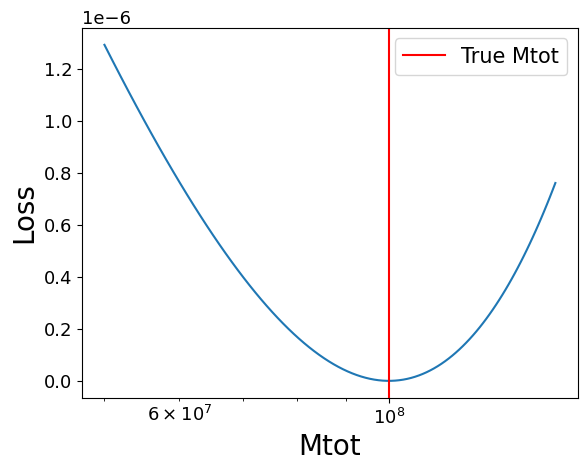

In [8]:
Mtot =  (jnp.linspace(0.5*1e8, 1.5*1e8, 100) * u.Msun).to(code_units.code_mass).value
loss = vmap(time_integration_for_mass_grad)(Mtot)

plt.figure()
plt.plot((Mtot*code_units.code_mass).to(u.Msun), loss)
plt.axvline((1e8 * u.Msun).value, color='r', label='True Mtot')
plt.xlabel('Mtot')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [9]:
target_state = time_integration(initial_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(t_end, ):
    params = SimulationParams(t_end = t_end,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10  * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    pos = sample_position_on_sphere(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    # Calculate the acceleration at the center of mass
    acc_com, _ = MyamotoNagai(state_com, config, params, return_potential=True)
    #circular velocity at the center of mass
    v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
    inclination = jnp.radians(30)  # 30-degree inclination
    #bulk motion to give to each particle of the Plummer sphere
    vel = inclined_circular_velocity(pos, v_c, inclination)
    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    loss = ((Lz - Lz_target)/Lz_target)**2 
    # loss = ((energy- energy_target)/energy_target)**2
    # loss = ((Lz - Lz_target)/Lz_target)**2  + ((energy- energy_target)/energy_target)**2

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (1*u.Gyr).to(code_units.code_time).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(t_end, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Plummer sphere:
 0.0
Loss:
 0.0


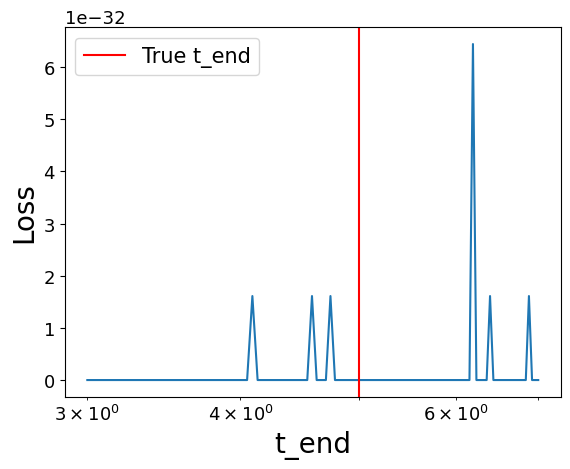

In [10]:
t_end =  (jnp.linspace(3, 7, 100) * u.Myr).to(code_units.code_time).value
loss = vmap(time_integration_for_mass_grad)(t_end)

plt.figure()
plt.plot((t_end*code_units.code_time).to(u.Myr), loss)
plt.axvline((5 * u.Gyr).value, color='r', label='True t_end')
plt.xlabel('t_end')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [11]:
target_state = time_integration(initial_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]

def time_integration_for_mass_grad(M_tot, t_end, ):
    params = SimulationParams(t_end = t_end,  
                          Plummer_params= PlummerParams(Mtot=M_tot,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10  * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
    pos = sample_position_on_sphere(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    # Calculate the acceleration at the center of mass
    acc_com, _ = MyamotoNagai(state_com, config, params, return_potential=True)
    #circular velocity at the center of mass
    v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
    inclination = jnp.radians(30)  # 30-degree inclination
    #bulk motion to give to each particle of the Plummer sphere
    vel = inclined_circular_velocity(pos, v_c, inclination)
    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    final_state = time_integration(initial_state, mass, config, params)
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    loss = ((Lz - Lz_target)/Lz_target)**2 
    # loss = ((energy- energy_target)/energy_target)**2
    # loss = ((Lz - Lz_target)/Lz_target)**2  + ((energy- energy_target)/energy_target)**2

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (0.1*u.Gyr).to(code_units.code_time).value
M_tot = (0.75e8 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(M_tot, t_end, )
print("Gradient of the total mass of the Plummer sphere:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Plummer sphere:
 -2.3309990522127422e-06
Loss:
 2.7045510625412765e-07


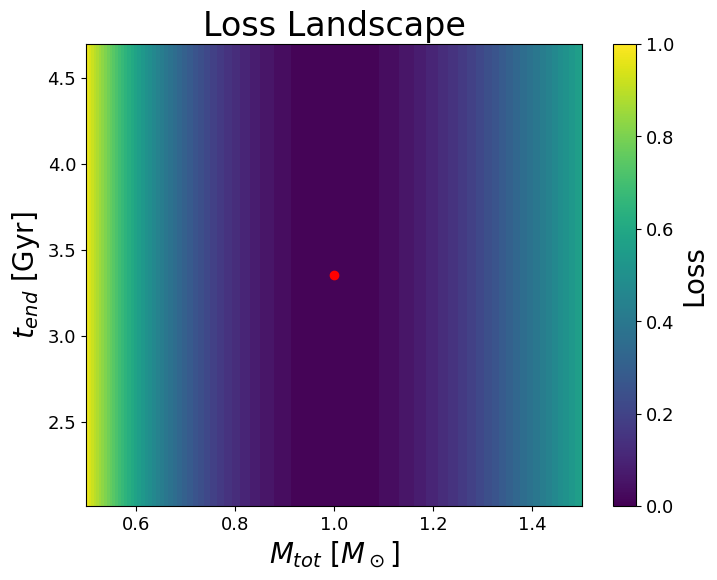

In [12]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

# Define the range of M_tot and t_end values
M_tot_values = (jnp.linspace(0.5e8, 1.5e8, 50)*u.Msun).to(code_units.code_mass).value  # Adjust range based on expected values
t_end_values = (jnp.linspace(3, 7, 50)*u.Gyr).to(code_units.code_time).value     # Adjust range based on expected timescales

# Create a meshgrid
M_tot_grid, t_end_grid = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Vectorize the loss function over a single input (M_tot, t_end)
batched_loss_fn = jax.vmap(time_integration_for_mass_grad, in_axes=(0, 0))

# Flatten the grid for batch processing
M_tot_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()

# Compute losses in parallel
loss_values_flat = batched_loss_fn(M_tot_flat, t_end_flat)

# Reshape back to grid
loss_values = loss_values_flat.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values, t_end_values, loss_values.T, levels=50, cmap="viridis")
plt.scatter((1e8 * u.Msun).to(code_units.code_mass).value, (5 * u.Gyr).to(code_units.code_time).value, color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$M_{tot}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("Loss Landscape")
plt.show()
